In [64]:
import sys
sys.path.insert(0, './sequence')

from sequence.utils import copy_from_gcs
from sequence.trainer.utils import load_data, deduce_look_back, scale, replace_expected_look_back, update_prediction_history
from sequence.trainer.model import create_model, compile_model
import numpy as np
from tempfile import NamedTemporaryFile
%matplotlib inline
import matplotlib.pyplot as plt

In [79]:
params = {
    'eval-file': 'gs://vehicle-simulation/jobs/sequence/008/data/test.csv',
    'model-weights-file': 'gs://vehicle-simulation/jobs/sequence/008/weights/E012L1.526040E-03.hdf5',
    'first-layer-size': 200,
    'num-layers': 4,
    'scale-factor': 0.5,
    'hidden-layer': 'LSTM',
    'hidden-activation': 'tanh',
    'output-activation': 'linear',
    'hidden-dropout': 0.4,
    'optimizer': 'RMSprop',
    'learning-rate': 0.001,
    'loss': 'mean_squared_error'
}

In [86]:
X_test, in_features, Y_test, out_features = load_data(params['eval-file'])

X_test_scaled, _, _ = scale(X_test, min=0., max=1., pad_old=-1.)
Y_test_scaled, _, _ = scale(Y_test, min=0., max=1., pad_old=-1.)

In [87]:
n_samples, _, n_in_features = X_test.shape
n_samples, _, n_out_features = Y_test.shape

eval_model = create_model(batch_input_shape=(n_samples, 1, n_in_features), 
                          hidden_units=[int(params['first-layer-size'] * params['scale-factor'] ** i) for i in range(params['num-layers'])],
                          target_dim=(n_samples, 1, n_out_features),
                          hidden_layer=params['hidden-layer'],
                          hidden_activation=params['hidden-activation'],
                          output_activation=params['output-activation'],
                          hidden_dropout=params['hidden-dropout'])

compile_model(eval_model, params['optimizer'], params['learning-rate'], params['loss'])

with NamedTemporaryFile() as weights_file:
    
    copy_from_gcs(params['model-weights-file'], weights_file.name)
    
    eval_model.load_weights(weights_file.name)

In [82]:
n_look_back_features, look_back_length = deduce_look_back(in_features, out_features)

Y_pred = np.zeros(Y_test.shape)
Y_pred_hist = np.zeros((Y_test.shape[0], look_back_length, Y_test.shape[1]))

for t in range(10000):
    
    X_t = replace_expected_look_back(X_test_scaled[:, t:t + 1, :], Y_pred_hist, n_look_back_features)
    
    Y_pred[:, t:t + 1, :] = eval_model.predict(X_t)
    
    Y_pred_hist = update_prediction_history(Y_pred_hist, Y_pred[:, t:t + 1, :])

(-0.1, 1.1)

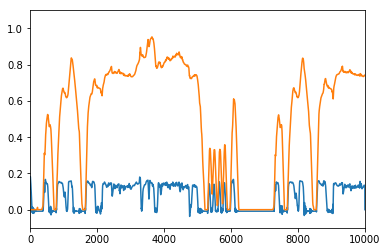

In [83]:
fig, ax = plt.subplots()

ax.plot(range(Y_pred.shape[1]), Y_pred[0,:,0])
ax.plot(range(Y_test_scaled.shape[1]), Y_test_scaled[0,:,0])

ax.set_xlim(0, 10000)
ax.set_ylim(-0.1, 1.1)

In [90]:
n_look_back_features, look_back_length = deduce_look_back(in_features, out_features)

Y_pred = np.zeros(Y_test.shape)
Y_pred_hist = np.zeros((Y_test.shape[0], look_back_length, Y_test.shape[1]))

for t in range(10000):
    
    Y_pred[:, t:t + 1, :] = eval_model.predict(X_test_scaled[:, t:t + 1, :])

(-0.1, 1.1)

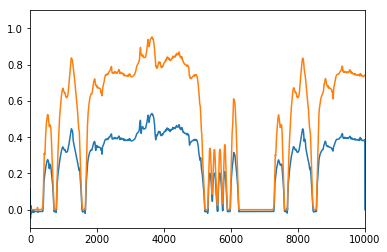

In [91]:
fig, ax = plt.subplots()

ax.plot(range(Y_pred.shape[1]), Y_pred[0,:,0])
ax.plot(range(Y_test_scaled.shape[1]), Y_test_scaled[0,:,0])

ax.set_xlim(0, 10000)
ax.set_ylim(-0.1, 1.1)